# Mobility data anlaysis (Matt)

In [1]:
# imports and setup
from   ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   scipy.stats import permutation_test
import seaborn as sns
from   sklearn.preprocessing import LabelBinarizer
import string
import warnings

data_dir = os.path.join('..', 'data')
derived_dir = os.path.join(data_dir, 'derived')
metadata_dir = os.path.join(data_dir, 'metadata')

## Load data

### Mobility

In [2]:
def string_to_list(x):
    lst = literal_eval(x.replace(', nan', "', ZZZZ'").replace('[nan, ', "'['").replace(', nan]', "']'"))
    return [i for i in lst if i != 'ZZZZ']

def index_int_string(idx):
    '''Make Chicago index labels consistent'''
    try:
        int(idx)
        return(str(idx).rjust(8, '0'))
    except ValueError:
        return(idx)

conlit = pd.read_csv(
    os.path.join(derived_dir, 'CONLIT_CharData_AP_MW_5.csv.gz'), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
conlit['source'] = 'conlit'

early = pd.read_csv(
    os.path.join(derived_dir, 'EARLY_CharData_MW.csv.gz'), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
early.index = early.index.to_series().apply(index_int_string)

# set source corpus for EARLY data
def source_mapper(label):
    if label.startswith('eaf'):
        return('eaf')
    elif label.startswith('Wright'):
        return('wright')
    else:
        return('chicago')

early['source'] = early.index.to_series().apply(source_mapper)

### Temporary calculations for EARLY

Will work with Andrew's data when available. Calculating a few for immediate use.

**Remove this cell as redundant when Andrew's data is in hand**

In [3]:
early['avg_Distance_GPE_Tokens'] = early.dist_miles.divide(early.Tokens)
early['gpe_places_total'] = early.gpe_places.apply(len)
early['avg_Distance_GPE'] = early.dist_miles.divide(early.gpe_places_total).fillna(0)

### Metadata

In [4]:
# EAF and Wright
eaf = pd.read_csv(
    os.path.join(data_dir, 'metadata', 'eaf-wright-metadata.tsv'), 
    sep='\t', 
    index_col='source_id'
)
eaf.index.rename('book_id', inplace=True)
eaf.rename(columns={'gender':'author_gender'}, inplace=True)

# Chicago
chi = pd.read_csv(
    os.path.join(metadata_dir, 'chicago-books.csv'),
    index_col='BOOK_ID'
)
chi.index.rename('book_id', inplace=True)
chi.index = chi.index.to_series().apply(index_int_string)
chi.columns = [i.lower() for i in chi.columns]

chi_auth = pd.read_csv(
    os.path.join(metadata_dir, 'chicago-authors.csv'),
)
chi_auth.columns = [i.lower() for i in chi_auth.columns]

chi_idx = chi.index
chi = chi.merge(chi_auth[['auth_id', 'gender']], how='left', on='auth_id').set_index(chi_idx)
chi.rename(columns={'gender':'author_gender', 'publ_date':'pub_date'}, inplace=True)
chi['author'] = chi[['auth_last', 'auth_first']].agg(', '.join, axis=1)

# CONLIT
con = pd.read_csv(
    os.path.join(metadata_dir, 'CONLIT_META.csv'),
    index_col='ID'
)
con.index.rename('book_id', inplace=True)
con.index = con.index.to_series().apply(lambda x: x[:-4]) #delete '.txt'
# fix up indexing errors
con.rename(
    index={
        '2009_LaFleur,Suzanne_Love,Aubrey_MGtxt':'2009_LaFleur,Suzanne_Love,Aubrey_M', 
        '2015_Jackson,AL_ComeToMeRecklessly_ROM.txt':'2015_Jackson,AL_ComeToMeRecklessly_ROM'
    }, \
    inplace=True
)
con.columns = [i.lower() for i in con.columns]
con.rename(columns={'pubdate':'pub_date', 'work_title':'title'}, inplace=True)
con['author'] = con[['author_last', 'author_first']].fillna('').astype(str).agg(', '.join, axis=1)

# integrate target columns
cols = ['author', 'title', 'pub_date', 'author_gender']
meta = pd.concat([eaf[cols], chi[cols], con[cols]], axis=0)

### Integrate

In [5]:
conlit = conlit.join(meta[['pub_date', 'author_gender']])
early = early.join(meta[['pub_date', 'author_gender']])
early['Category'] = 'FIC'

## Feature differences by facet 

### CONLIT

In [6]:
def significance_label(pvalue, levels=[0.05, 0.01, 0.001]):
    if pvalue < levels[2]:
        return '***'
    elif pvalue < levels[1]:
        return '**'
    elif pvalue < levels[0]:
        return '*'
    else: 
        return ''

def diff_means(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

def compare_facets(df, facets, cols_to_drop, statistic=diff_means):
    '''Compare statistic in numeric cols of df via permutation. Display results, return nothing.'''
    cols = df.select_dtypes(include='number').drop(columns=cols_to_drop).columns
    for facet in facets:
        print(f"\n==============\nFacet: {facet}\n==============")
        df = df.dropna(subset=[facet])
        for level in df[facet].unique():
            data = (df.loc[df[facet]==level, cols], df.loc[~(df[facet]==level), cols])
            level_mean = np.mean(data[0], axis=0)
            other_mean = np.mean(data[1], axis=0)
            output = pd.DataFrame(level_mean, columns=[level]).join(pd.DataFrame(other_mean, columns=['others']))
            res = permutation_test(data, statistic)
            output['diff'] = res.statistic
            output['p'] = res.pvalue
            output['sig'] = output['p'].apply(significance_label)
            display(output)

In [7]:
facet_by = ['inf_gender', 'Category', 'Genre', 'author_gender']
ignore_numeric_cols = ['char_id', 'char_rank', 'num_words']
compare_facets(conlit, facet_by, ignore_numeric_cols, diff_means)


Facet: inf_gender


,she/her,others,diff,p,sig
char_count,3752.279775,3844.495428,-92.215652,0.3874,
num_gpe_places,16.356180,21.814954,-5.458775,0.0002,***
num_nongpe_places,122.757303,123.285637,-0.528334,0.8622,
num_all_places,138.620225,144.524476,-5.904251,0.0940,
dist_miles,51501.447552,72756.670191,-21255.222639,0.0002,***
Tokens,119516.989888,131900.656267,-12383.666379,0.0002,***
num_gpe_places_norm,0.000141,0.000170,-0.000029,0.0002,***
num_nongpe_places_norm,0.001127,0.001048,0.000079,0.0014,**
num_gpe_places_norm_byCharacter,0.005224,0.009569,-0.004345,0.0002,***
num_nongpe_places_norm_byCharacter,0.036178,0.037657,-0.001479,0.0420,*


,he/him/his,others,diff,p,sig
char_count,4012.726801,3475.705128,537.021673,0.0002,***
num_gpe_places,22.025360,16.663708,5.361652,0.0002,***
num_nongpe_places,127.342939,115.879684,11.463255,0.0002,***
num_all_places,148.785591,132.051282,16.734309,0.0002,***
dist_miles,73533.779439,52771.036370,20762.743069,0.0002,***
Tokens,133472.337752,118342.144970,15130.192782,0.0002,***
num_gpe_places_norm,0.000169,0.000146,0.000023,0.0004,***
num_nongpe_places_norm,0.001073,0.001074,-0.000001,0.9576,
num_gpe_places_norm_byCharacter,0.008396,0.007762,0.000634,0.1642,
num_nongpe_places_norm_byCharacter,0.036880,0.037687,-0.000807,0.2550,


,they/them/their,others,diff,p,sig
char_count,1490.612903,3924.422857,-2433.809954,0.0002,***
num_gpe_places,18.870968,20.103238,-1.232270,0.5540,
num_nongpe_places,66.516129,125.788190,-59.272061,0.0002,***
num_all_places,84.903226,145.339048,-60.435822,0.0002,***
dist_miles,61883.407727,66063.769770,-4180.362043,0.7078,
Tokens,109909.790323,128740.810286,-18831.019963,0.0018,**
num_gpe_places_norm,0.000183,0.000160,0.000024,0.0844,
num_nongpe_places_norm,0.000695,0.001091,-0.000396,0.0002,***
num_gpe_places_norm_byCharacter,0.025981,0.007321,0.018660,0.0002,***
num_nongpe_places_norm_byCharacter,0.048523,0.036642,0.011881,0.0002,***



Facet: Category


,FIC,others,diff,p,sig
char_count,4206.708441,2889.110024,1317.598417,0.0002,***
num_gpe_places,13.348006,35.863081,-22.515074,0.0002,***
num_nongpe_places,123.981875,121.067237,2.914638,0.3548,
num_all_places,136.915070,156.063570,-19.148500,0.0002,***
dist_miles,38036.039103,131593.333370,-93557.294267,0.0002,***
Tokens,121689.747281,142531.221271,-20841.473990,0.0002,***
num_gpe_places_norm,0.000117,0.000263,-0.000146,0.0002,***
num_nongpe_places_norm,0.001116,0.000972,0.000144,0.0002,***
num_gpe_places_norm_byCharacter,0.003801,0.018457,-0.014656,0.0002,***
num_nongpe_places_norm_byCharacter,0.033272,0.046399,-0.013127,0.0002,***


,NON,others,diff,p,sig
char_count,2889.110024,4206.708441,-1317.598417,0.0002,***
num_gpe_places,35.863081,13.348006,22.515074,0.0002,***
num_nongpe_places,121.067237,123.981875,-2.914638,0.3532,
num_all_places,156.063570,136.915070,19.148500,0.0002,***
dist_miles,131593.333370,38036.039103,93557.294267,0.0002,***
Tokens,142531.221271,121689.747281,20841.473990,0.0002,***
num_gpe_places_norm,0.000263,0.000117,0.000146,0.0002,***
num_nongpe_places_norm,0.000972,0.001116,-0.000144,0.0002,***
num_gpe_places_norm_byCharacter,0.018457,0.003801,0.014656,0.0002,***
num_nongpe_places_norm_byCharacter,0.046399,0.033272,0.013127,0.0002,***



Facet: Genre


,YA,others,diff,p,sig
char_count,5664.129944,3687.361975,1976.767968,0.0002,***
num_gpe_places,11.519774,20.634526,-9.114752,0.0002,***
num_nongpe_places,130.824859,122.583981,8.240877,0.1610,
num_all_places,141.903955,142.661742,-0.757787,0.9432,
dist_miles,28737.615271,68430.941020,-39693.325749,0.0002,***
Tokens,106057.067797,129393.989114,-23336.921317,0.0002,***
num_gpe_places_norm,0.000113,0.000164,-0.000051,0.0002,***
num_nongpe_places_norm,0.001257,0.001061,0.000196,0.0002,***
num_gpe_places_norm_byCharacter,0.002359,0.008562,-0.006202,0.0002,***
num_nongpe_places_norm_byCharacter,0.024377,0.038059,-0.013682,0.0002,***


,SF,others,diff,p,sig
char_count,3852.243243,3811.336763,40.906480,0.8020,
num_gpe_places,12.747748,20.688959,-7.941211,0.0002,***
num_nongpe_places,116.711712,123.677087,-6.965376,0.1818,
num_all_places,128.842342,143.822715,-14.980372,0.0122,*
dist_miles,31137.835935,68926.924665,-37789.088730,0.0002,***
Tokens,144376.954955,126443.117135,17933.837820,0.0008,***
num_gpe_places_norm,0.000098,0.000166,-0.000068,0.0002,***
num_nongpe_places_norm,0.000902,0.001088,-0.000186,0.0002,***
num_gpe_places_norm_byCharacter,0.003721,0.008553,-0.004831,0.0002,***
num_nongpe_places_norm_byCharacter,0.031815,0.037649,-0.005835,0.0002,***


,BS,others,diff,p,sig
char_count,4729.730924,3723.497200,1006.233724,0.0002,***
num_gpe_places,17.694779,20.282000,-2.587221,0.0610,
num_nongpe_places,143.425703,121.091600,22.334103,0.0002,***
num_all_places,160.618474,140.819600,19.798874,0.0016,**
dist_miles,49632.755582,67492.952826,-17860.197244,0.0072,**
Tokens,155119.140562,125179.510000,29939.630562,0.0002,***
num_gpe_places_norm,0.000126,0.000164,-0.000038,0.0002,***
num_nongpe_places_norm,0.001017,0.001079,-0.000062,0.1256,
num_gpe_places_norm_byCharacter,0.004617,0.008516,-0.003899,0.0002,***
num_nongpe_places_norm_byCharacter,0.034983,0.037397,-0.002413,0.0390,*


,NYT,others,diff,p,sig
char_count,3719.703349,3831.664522,-111.961172,0.4130,
num_gpe_places,16.351675,20.710425,-4.358750,0.0002,***
num_nongpe_places,129.624402,121.947233,7.677169,0.0526,
num_all_places,145.581340,142.080652,3.500688,0.4532,
dist_miles,52104.402460,68344.615177,-16240.212717,0.0026,**
Tokens,118268.789474,129616.939940,-11348.150466,0.0014,**
num_gpe_places_norm,0.000150,0.000163,-0.000013,0.0990,
num_nongpe_places_norm,0.001194,0.001052,0.000142,0.0002,***
num_gpe_places_norm_byCharacter,0.004899,0.008748,-0.003848,0.0002,***
num_nongpe_places_norm_byCharacter,0.037954,0.037039,0.000915,0.3330,


,MY,others,diff,p,sig
char_count,4099.149573,3788.168986,310.980587,0.1004,
num_gpe_places,13.286325,20.676740,-7.390415,0.0002,***
num_nongpe_places,132.316239,122.258449,10.057790,0.0532,
num_all_places,145.226496,142.369781,2.856714,0.6482,
dist_miles,33531.764764,68884.495129,-35352.730365,0.0002,***
Tokens,124630.961538,128194.749901,-3563.788362,0.4374,
num_gpe_places_norm,0.000109,0.000166,-0.000057,0.0002,***
num_nongpe_places_norm,0.001113,0.001070,0.000044,0.2864,
num_gpe_places_norm_byCharacter,0.003733,0.008574,-0.004841,0.0002,***
num_nongpe_places_norm_byCharacter,0.034180,0.037457,-0.003277,0.0048,**


,ROM,others,diff,p,sig
char_count,5970.480769,3638.168438,2332.312332,0.0002,***
num_gpe_places,7.625000,21.064542,-13.439542,0.0002,***
num_nongpe_places,108.990385,124.270760,-15.280375,0.0020,**
num_all_places,116.403846,144.758363,-28.354517,0.0002,***
dist_miles,20950.401077,69552.638639,-48602.237562,0.0002,***
Tokens,103573.639423,129881.985045,-26308.345622,0.0002,***
num_gpe_places_norm,0.000075,0.000168,-0.000093,0.0002,***
num_nongpe_places_norm,0.001099,0.001071,0.000028,0.5290,
num_gpe_places_norm_byCharacter,0.001397,0.008716,-0.007319,0.0002,***
num_nongpe_places_norm_byCharacter,0.019871,0.038595,-0.018724,0.0002,***


,HIST,others,diff,p,sig
char_count,987.385366,4042.465409,-3055.080043,0.0002,***
num_gpe_places,20.839024,19.983884,0.855141,0.5774,
num_nongpe_places,48.063415,129.162343,-81.098928,0.0002,***
num_all_places,68.556098,148.580582,-80.024484,0.0002,***
dist_miles,59830.022183,66362.336343,-6532.314160,0.4030,
Tokens,148252.897561,126250.627752,22002.269809,0.0004,***
num_gpe_places_norm,0.000152,0.000161,-0.000009,0.3816,
num_nongpe_places_norm,0.000349,0.001132,-0.000783,0.0002,***
num_gpe_places_norm_byCharacter,0.030387,0.006371,0.024016,0.0002,***
num_nongpe_places_norm_byCharacter,0.051873,0.035994,0.015879,0.0002,***


,PW,others,diff,p,sig
char_count,3177.618677,3880.336276,-702.717599,0.0002,***
num_gpe_places,14.801556,20.588684,-5.787127,0.0002,***
num_nongpe_places,121.428016,123.288523,-1.860508,0.7144,
num_all_places,135.782101,143.317416,-7.535315,0.1934,
dist_miles,49045.545388,67610.847930,-18565.302541,0.0042,**
Tokens,122261.315175,128472.023676,-6210.708501,0.1548,
num_gpe_places_norm,0.000134,0.000163,-0.000029,0.0018,**
num_nongpe_places_norm,0.001108,0.001070,0.000038,0.3268,
num_gpe_places_norm_byCharacter,0.005194,0.008469,-0.003275,0.0002,***
num_nongpe_places_norm_byCharacter,0.042319,0.036648,0.005672,0.0002,***


,MIX,others,diff,p,sig
char_count,1869.167539,3959.904222,-2090.736683,0.0002,***
num_gpe_places,25.450262,19.644253,5.806008,0.0010,**
num_nongpe_places,84.507853,125.997263,-41.489410,0.0002,***
num_all_places,109.403141,145.092651,-35.689509,0.0002,***
dist_miles,98662.101411,63427.082422,35235.018989,0.0002,***
Tokens,126088.335079,128026.023847,-1937.688768,0.7222,
num_gpe_places_norm,0.000204,0.000157,0.000047,0.0002,***
num_nongpe_places_norm,0.000745,0.001098,-0.000352,0.0002,***
num_gpe_places_norm_byCharacter,0.018654,0.007379,0.011275,0.0002,***
num_nongpe_places_norm_byCharacter,0.046469,0.036484,0.009985,0.0002,***


,MEM,others,diff,p,sig
char_count,4260.253275,3774.146032,486.107243,0.0092,**
num_gpe_places,37.877729,18.427381,19.450348,0.0002,***
num_nongpe_places,170.908297,118.771429,52.136868,0.0002,***
num_all_places,207.737991,136.694841,71.043150,0.0002,***
dist_miles,147811.848938,58429.374920,89382.474018,0.0002,***
Tokens,105611.161572,129916.065476,-24304.903904,0.0002,***
num_gpe_places_norm,0.000355,0.000143,0.000212,0.0002,***
num_nongpe_places_norm,0.001666,0.001019,0.000646,0.0002,***
num_gpe_places_norm_byCharacter,0.009739,0.008019,0.001720,0.0528,
num_nongpe_places_norm_byCharacter,0.041595,0.036777,0.004819,0.0004,***


,MID,others,diff,p,sig
char_count,3103.355422,3860.351916,-756.996495,0.0008,***
num_gpe_places,7.024096,20.884630,-13.860534,0.0002,***
num_nongpe_places,94.024096,124.984127,-30.960031,0.0002,***
num_all_places,100.753012,145.303136,-44.550124,0.0002,***
dist_miles,15068.771786,69140.349241,-54071.577454,0.0002,***
Tokens,84156.487952,130702.076655,-46545.588703,0.0002,***
num_gpe_places_norm,0.000089,0.000165,-0.000076,0.0002,***
num_nongpe_places_norm,0.001243,0.001062,0.000181,0.0004,***
num_gpe_places_norm_byCharacter,0.002412,0.008532,-0.006120,0.0002,***
num_nongpe_places_norm_byCharacter,0.031853,0.037520,-0.005667,0.0002,***


,BIO,others,diff,p,sig
char_count,4291.549223,3778.629499,512.919724,0.0160,*
num_gpe_places,59.735751,17.050861,42.684891,0.0002,***
num_nongpe_places,175.652850,119.147496,56.505354,0.0002,***
num_all_places,233.875648,135.721831,98.153817,0.0002,***
dist_miles,221164.856853,54149.499543,167015.357310,0.0002,***
Tokens,196532.989637,122708.362285,73824.627352,0.0002,***
num_gpe_places_norm,0.000331,0.000148,0.000184,0.0002,***
num_nongpe_places_norm,0.001036,0.001076,-0.000040,0.3784,
num_gpe_places_norm_byCharacter,0.015934,0.007576,0.008359,0.0002,***
num_nongpe_places_norm_byCharacter,0.046214,0.036496,0.009718,0.0002,***



Facet: author_gender


,F,others,diff,p,sig
char_count,4328.822238,3306.769008,1022.053231,0.0002,***
num_gpe_places,16.027067,24.035482,-8.008415,0.0002,***
num_nongpe_places,125.130944,121.149891,3.981052,0.1608,
num_all_places,140.689832,144.555395,-3.865563,0.2594,
dist_miles,50658.591772,80975.092233,-30316.500462,0.0002,***
Tokens,115352.820044,140359.490949,-25006.670905,0.0002,***
num_gpe_places_norm,0.000142,0.000179,-0.000037,0.0002,***
num_nongpe_places_norm,0.001166,0.000981,0.000186,0.0002,***
num_gpe_places_norm_byCharacter,0.005483,0.010818,-0.005335,0.0002,***
num_nongpe_places_norm_byCharacter,0.033604,0.040718,-0.007114,0.0002,***


,M,others,diff,p,sig
char_count,3300.247633,4329.387636,-1029.140003,0.0002,***
num_gpe_places,24.102695,16.006545,8.096149,0.0002,***
num_nongpe_places,121.115076,125.142545,-4.027469,0.1476,
num_all_places,144.586307,140.681455,3.904853,0.2512,
dist_miles,81232.636008,50577.809518,30654.826490,0.0002,***
Tokens,140543.662054,115314.410182,25229.251872,0.0002,***
num_gpe_places_norm,0.000179,0.000142,0.000037,0.0002,***
num_nongpe_places_norm,0.000979,0.001167,-0.000187,0.0002,***
num_gpe_places_norm_byCharacter,0.010857,0.005475,0.005381,0.0002,***
num_nongpe_places_norm_byCharacter,0.040762,0.033601,0.007161,0.0002,***


,o,others,diff,p,sig
char_count,4426.000000,3813.408759,612.591241,0.4496,
num_gpe_places,12.500000,20.073723,-7.573723,0.2930,
num_nongpe_places,127.125000,123.118613,4.006387,0.8262,
num_all_places,139.250000,142.642336,-3.392336,0.9862,
dist_miles,36774.141922,65979.089121,-29204.947199,0.4346,
Tokens,108751.125000,127975.822263,-19224.697263,0.4226,
num_gpe_places_norm,0.000113,0.000161,-0.000048,0.3420,
num_nongpe_places_norm,0.001220,0.001073,0.000148,0.4790,
num_gpe_places_norm_byCharacter,0.004202,0.008175,-0.003973,0.2366,
num_nongpe_places_norm_byCharacter,0.033178,0.037191,-0.004012,0.5506,


### EARLY

In [8]:
facet_by = ['inf_gender', 'source', 'author_gender']
ignore_numeric_cols = ['char_id', 'char_rank']
compare_facets(early, facet_by, ignore_numeric_cols, diff_means)


Facet: inf_gender


,she/her,others,diff,p,sig
char_count,3151.009276,2826.725071,324.284204,0.0002,***
num_gpe_places,10.840215,11.488369,-0.648153,0.0024,**
num_nongpe_places,98.153202,90.792001,7.361201,0.0002,***
num_all_places,108.666966,101.966807,6.700159,0.0002,***
dist_miles,28731.134875,29730.119332,-998.984457,0.3160,
Tokens,119471.410533,114079.797851,5391.612682,0.0004,***
avg_Distance_GPE_Tokens,0.238184,0.253843,-0.015659,0.0338,*
gpe_places_total,32.037403,32.590940,-0.553537,0.4968,
avg_Distance_GPE,755.101132,778.181652,-23.080520,0.1134,
pub_date,1953.205865,1947.561964,5.643900,0.0002,***


,he/him/his,others,diff,p,sig
char_count,2839.052502,3119.199823,-280.147322,0.0002,***
num_gpe_places,11.521179,10.780459,0.740720,0.0018,**
num_nongpe_places,91.156408,97.249559,-6.093150,0.0002,***
num_all_places,102.363125,107.705709,-5.342584,0.0008,***
dist_miles,29818.492460,28557.874476,1260.617984,0.2034,
Tokens,114450.075394,118587.624485,-4137.549091,0.0032,**
avg_Distance_GPE_Tokens,0.253910,0.238298,0.015612,0.0318,*
gpe_places_total,32.697738,31.817245,0.880493,0.2772,
avg_Distance_GPE,778.301199,755.224858,23.076341,0.1068,
pub_date,1947.857848,1952.477634,-4.619786,0.0002,***


,they/them/their,others,diff,p,sig
char_count,1283.641509,2936.268421,-1652.626912,0.0002,***
num_gpe_places,7.584906,11.304229,-3.719324,0.0030,**
num_nongpe_places,45.471698,93.329887,-47.858189,0.0002,***
num_all_places,52.849057,104.315977,-51.466921,0.0002,***
dist_miles,19234.576170,29468.620999,-10234.044829,0.0796,
Tokens,68470.773585,116000.479041,-47529.705456,0.0002,***
avg_Distance_GPE_Tokens,0.257580,0.248906,0.008674,0.7944,
gpe_places_total,19.660377,32.481485,-12.821108,0.0030,**
avg_Distance_GPE,802.132799,770.812808,31.319991,0.7368,
pub_date,1910.113208,1949.521241,-39.408033,0.0002,***


,ze/zem/zir/hir,others,diff,p,sig
char_count,111.666667,2928.867540,-2817.200873,0.0002,***
num_gpe_places,0.666667,11.288775,-10.622108,0.0026,**
num_nongpe_places,5.333333,93.117306,-87.783973,0.0002,***
num_all_places,6.000000,104.088400,-98.088400,0.0002,***
dist_miles,257.392635,29426.079307,-29168.686672,0.0150,*
Tokens,19447.666667,115791.927502,-96344.260836,0.0002,***
avg_Distance_GPE_Tokens,0.024184,0.249012,-0.224828,0.0794,
gpe_places_total,1.333333,32.426660,-31.093327,0.0040,**
avg_Distance_GPE,64.348159,771.166349,-706.818190,0.0272,*
pub_date,1889.666667,1949.342657,-59.675990,0.0552,



Facet: source


,chicago,others,diff,p,sig
char_count,3166.273025,1512.358442,1653.914584,0.0002,***
num_gpe_places,12.258494,5.504545,6.753949,0.0002,***
num_nongpe_places,101.718999,41.822078,59.896921,0.0002,***
num_all_places,113.617175,47.262987,66.354188,0.0002,***
dist_miles,32462.791036,11320.541308,21142.249727,0.0002,***
Tokens,119921.047853,91062.790260,28858.257593,0.0002,***
avg_Distance_GPE_Tokens,0.270014,0.123749,0.146264,0.0002,***
gpe_places_total,35.734076,12.708442,23.025635,0.0002,***
avg_Distance_GPE,796.112310,621.522945,174.589365,0.0002,***
pub_date,1965.370698,1853.963636,111.407062,0.0002,***


,wright,others,diff,p,sig
char_count,1618.560837,3070.968053,-1452.407217,0.0002,***
num_gpe_places,5.342205,11.934343,-6.592138,0.0002,***
num_nongpe_places,43.816540,98.469557,-54.653017,0.0002,***
num_all_places,49.079848,110.060263,-60.980416,0.0002,***
dist_miles,10476.904662,31484.685848,-21007.781186,0.0002,***
Tokens,92724.798479,118278.971061,-25554.172582,0.0002,***
avg_Distance_GPE_Tokens,0.122850,0.262708,-0.139858,0.0002,***
gpe_places_total,12.205323,34.623483,-22.418160,0.0002,***
avg_Distance_GPE,604.257478,789.159054,-184.901576,0.0002,***
pub_date,1862.470532,1958.803340,-96.332808,0.0002,***


,eaf,others,diff,p,sig
char_count,1283.413934,3006.724449,-1723.310514,0.0002,***
num_gpe_places,5.854508,11.545517,-5.691009,0.0002,***
num_nongpe_places,37.522541,95.750024,-58.227484,0.0002,***
num_all_places,43.346311,106.964233,-63.617922,0.0002,***
dist_miles,13139.200637,30196.338075,-17057.137438,0.0002,***
Tokens,87479.936475,117117.475649,-29637.539174,0.0002,***
avg_Distance_GPE_Tokens,0.125688,0.254843,-0.129155,0.0002,***
gpe_places_total,13.793033,33.308574,-19.515541,0.0002,***
avg_Distance_GPE,658.742764,776.334624,-117.591860,0.0002,***
pub_date,1835.625000,1954.763057,-119.138057,0.0002,***



Facet: author_gender


,M,others,diff,p,sig
char_count,2761.181887,3276.618546,-515.436659,0.0002,***
num_gpe_places,11.802467,10.578504,1.223964,0.0002,***
num_nongpe_places,89.535279,101.215753,-11.680474,0.0002,***
num_all_places,101.014593,111.477608,-10.463015,0.0002,***
dist_miles,30322.599533,28460.318942,1862.280591,0.0532,
Tokens,113963.353242,120545.922550,-6582.569308,0.0002,***
avg_Distance_GPE_Tokens,0.260673,0.231298,0.029375,0.0002,***
gpe_places_total,32.741989,32.561380,0.180608,0.8332,
avg_Distance_GPE,783.880798,750.730271,33.150527,0.0204,*
pub_date,1945.651723,1958.122761,-12.471038,0.0002,***


,F,others,diff,p,sig
char_count,3276.618546,2761.181887,515.436659,0.0002,***
num_gpe_places,10.578504,11.802467,-1.223964,0.0002,***
num_nongpe_places,101.215753,89.535279,11.680474,0.0002,***
num_all_places,111.477608,101.014593,10.463015,0.0002,***
dist_miles,28460.318942,30322.599533,-1862.280591,0.0566,
Tokens,120545.922550,113963.353242,6582.569308,0.0002,***
avg_Distance_GPE_Tokens,0.231298,0.260673,-0.029375,0.0002,***
gpe_places_total,32.561380,32.741989,-0.180608,0.8142,
avg_Distance_GPE,750.730271,783.880798,-33.150527,0.0182,*
pub_date,1958.122761,1945.651723,12.471038,0.0002,***


## Change over time

In [14]:
# combine data for easier plotting
data = pd.concat([conlit, early])

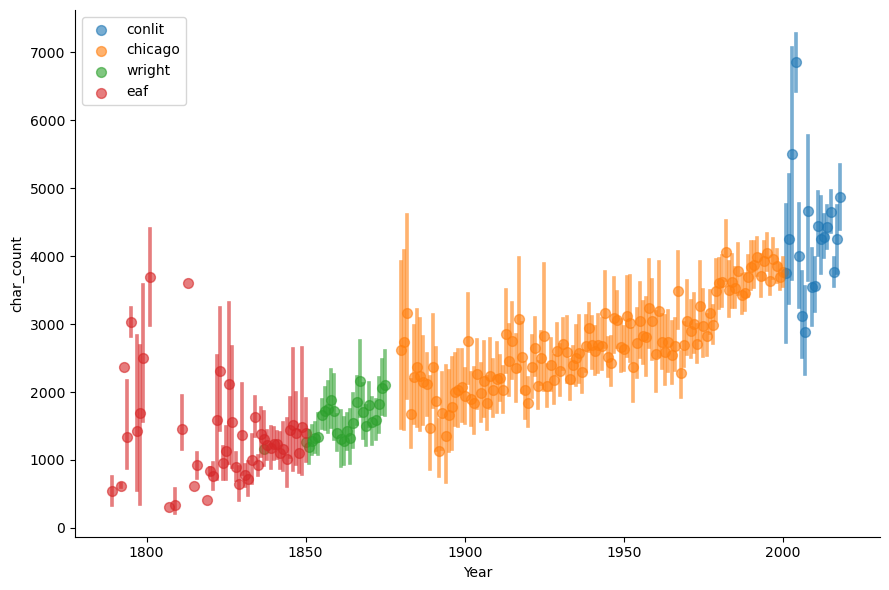

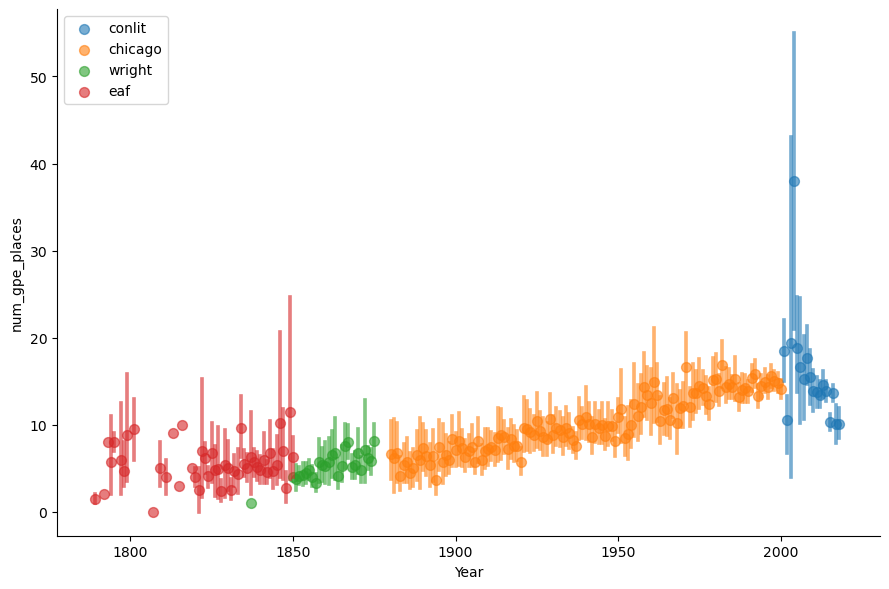

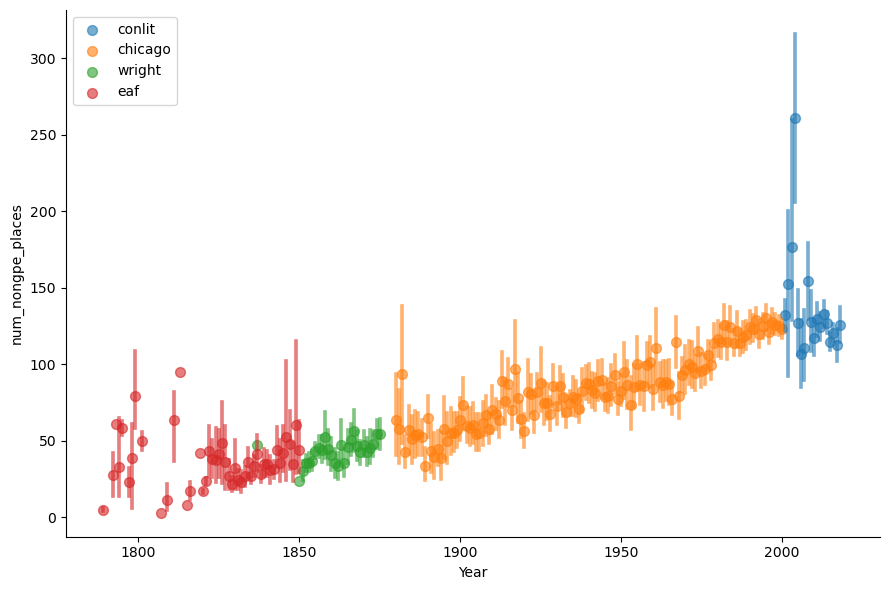

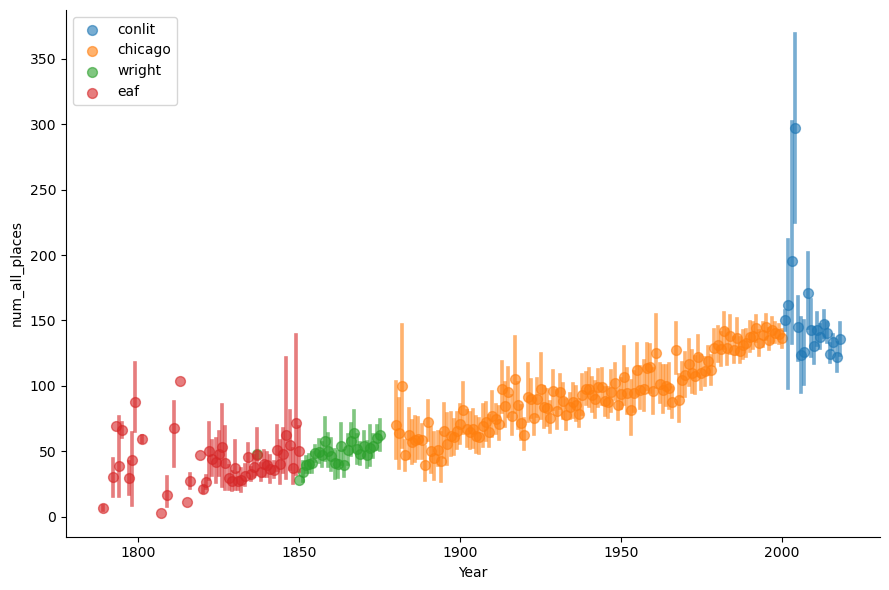

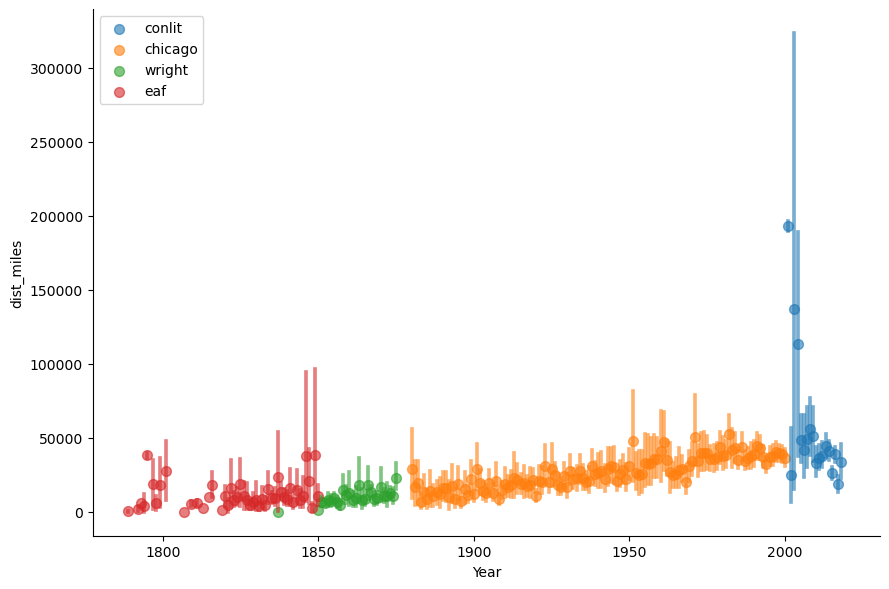

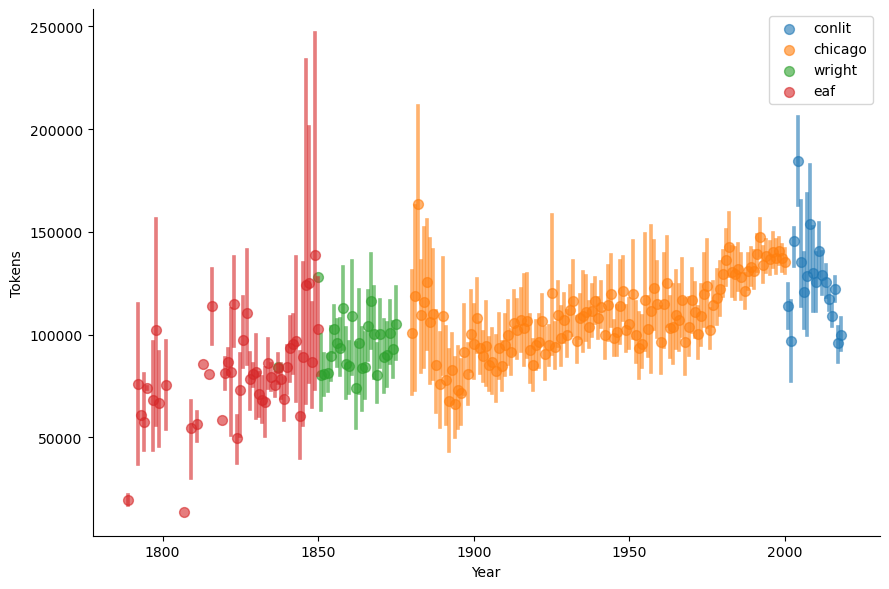

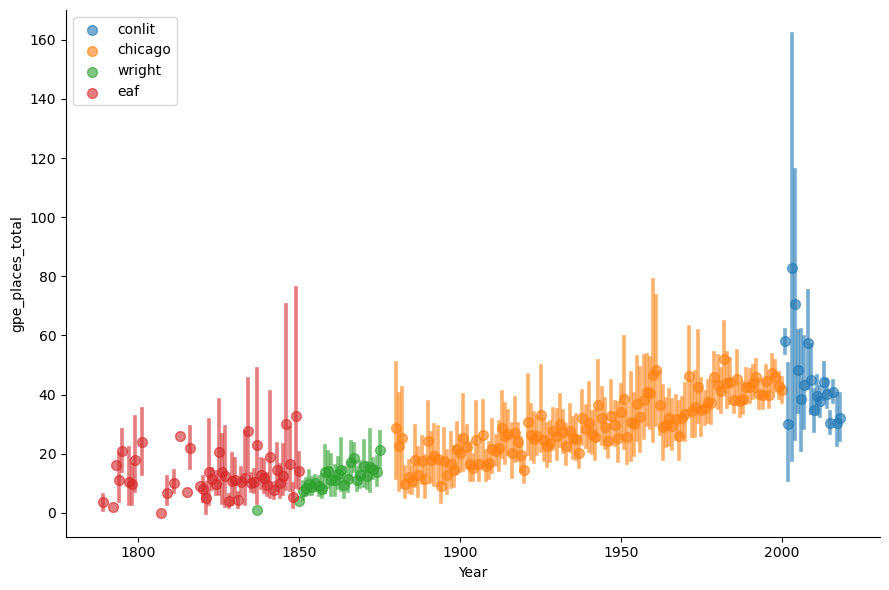

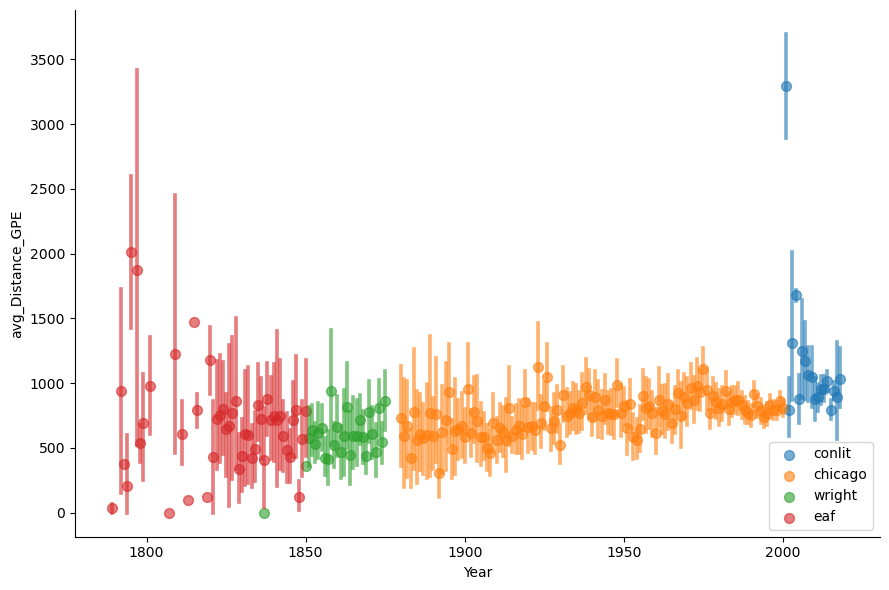

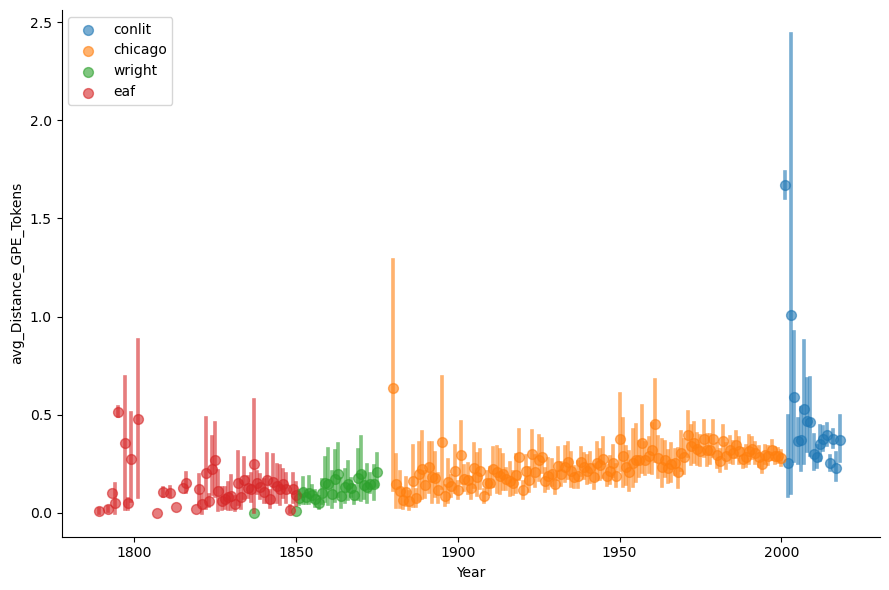

In [15]:
# plot features over time

# restrict to fiction
fic_data = data.loc[data.Category=='FIC']

# use all informative numeric columns
cols_to_drop_from_plot = ['char_id', 'char_rank', 'pub_date']
numeric_cols = fic_data[fic_data.columns[fic_data.notna().all()]].select_dtypes(include='number').drop(columns=cols_to_drop_from_plot).columns

# create plots
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = np.arange(fic_data.pub_date.min(), fic_data.pub_date.max(), 1)
    for col in numeric_cols:
        sns.lmplot(
            x='pub_date', 
            y=col, 
            data=fic_data, 
            #y_partial='Category', # control for fiction/nonfiction
            fit_reg=False,
            x_bins=bins, #fixed total bins by year
            #x_bins=10, # number of bins per source
            hue='source',
            legend=False,
            height=6,
            aspect=1.5,
            scatter_kws={'alpha':0.6}
        )
        plt.xlabel('Year')
        plt.ylabel(col)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

### Outliers

In [35]:
# highest avg distance per GPE
outliers = fic_data[['dist_miles', 'avg_Distance_GPE', 'avg_Distance_GPE_Tokens', 'source']].sort_values(by='avg_Distance_GPE', ascending=False).head(20).join(meta)
outliers

,dist_miles,avg_Distance_GPE,avg_Distance_GPE_Tokens,source,author,title,pub_date,author_gender
book_id,,,,,,,,
"2017_Thompson,Lisa_TheGoldfishBoy_MG",21289.717821,7096.572607,0.244791,conlit,"Thompson, Lisa",TheGoldfishBoy,2017,F
00011895,11918.674966,5959.337483,0.159020,chicago,"Taylor, Elizabeth",A wreath of roses,1949,F
00024828,29469.942611,5893.988522,0.243934,chicago,"Budnitz, Judy",If I told you once,1999,F
00011347,57803.253892,5254.841263,0.694509,chicago,"Wallace, Edgar",The just men of Cordova,1931,M
00010885,14324.979879,4774.993293,0.102408,chicago,"Buck, Pearl S.",Peony,1948,F
00003752,75469.987858,4716.874241,0.651761,chicago,"MacGrath, Harold",The adventures of Kathlyn,1914,M
00011526,9401.638640,4700.819320,0.079798,chicago,"Stewart, Alfred Walter",A minor operation,1937,M
00010452,37583.890361,4697.986295,0.403499,chicago,"Queen, Ellery",The Chinese orange mystery,1934,NaN
"2018_Mass,Wendy_Bob_MG",66670.430300,4541.691025,1.838493,conlit,"Mass, Wendy",Bob,2018,F


In [40]:
# high distance per GPE in CONLIT
print("CONLIT")
for item in conlit.loc[outliers.loc[outliers.source=='conlit'].index, 'gpe_sequences']:
    print(item)
    
print("\nEARLY")
for item in early.loc[outliers.loc[outliers.source!='conlit'].index, 'gpe_sequences']:
    print(item)

CONLIT
['New York', 'New Zealand', 'Spain']
['Australia', 'Egypt', 'Massachusetts', 'Australia', 'the United States', 'Yarn', 'Philippa', 'Istanbul', 'Singapore', 'Istanbul', 'Singapore', 'Finland', 'Tokyo']
['Perth', 'Chicago', 'Dakota', 'Sydney', 'Greece']
['Thornhill', 'Lambeth', 'Bermondsey', 'Cheapside', 'Newgate', 'New South Wales', 'Cape Town', 'Sydney Cove', 'Hawkesbury', 'Sydney', 'Cockle Bay', 'Paradise', 'London', 'Sydney', 'Eastcheap', 'Bermondsey']

EARLY
['Middlemarch', 'Bournemouth']
['Baba', 'Europe', 'Miami', 'Sidney', 'Lisbon']
['England', 'Australia', 'Spain', 'Serrington Gardens', 'England', 'Australia', 'Cheapside', 'London', 'Australia', 'England']
['Palestine', 'Kung', 'Peking']
['India', 'Allaha', 'Singapore', 'Ceylon', 'Hindustani', 'India', 'Hawaii', 'Allaha', 'Pundita', 'Allaha', 'Hind', 'India']
['Ravensthorpe', 'Glasgow']
['China', 'Bashan', 'New York', 'China', 'Chicago', 'China', 'Chicago']
['Massachusetts', 'Zanzibar', 'New England', 'Zanzibar', 'Stanley

Yeah, so these make sense. They're books with generally few GPEs that are widely separated.